##Bereinigte Daten einlesen


In [42]:
import pandas as pd
import Useful_functions_for_stations
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

In [43]:
bluebikes = pd.read_csv('C:/Users/lauri/PycharmProjects/DSML_Data/bluebikes_idle_time_v4.csv')
bluebikes.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,weekday,idle_time
0,2017-01-01 00:06:58,2017-01-01 00:12:49,67,139,644,6,0
1,2017-01-01 00:13:16,2017-01-01 00:28:07,36,10,230,6,0
2,2017-01-01 00:16:17,2017-01-01 00:44:10,36,9,980,6,0
3,2017-01-01 00:21:22,2017-01-01 00:33:50,46,19,1834,6,0
4,2017-01-01 00:30:06,2017-01-01 00:40:28,10,8,230,6,0 days 00:01:59


In [44]:
bluebikes_stations = pd.read_csv('C:/Users/lauri/PycharmProjects/DSML_Data/bluebikes_stations.csv')
bluebikes_stations.head()

,station_id,lat,lon
0,67,42.358100,-71.093198
1,139,42.361780,-71.108100
2,36,42.349792,-71.077338
3,10,42.350406,-71.108279
4,9,42.351187,-71.115852


Plot station map to show the current station network


Bar chart which shows number of trips originating from each station


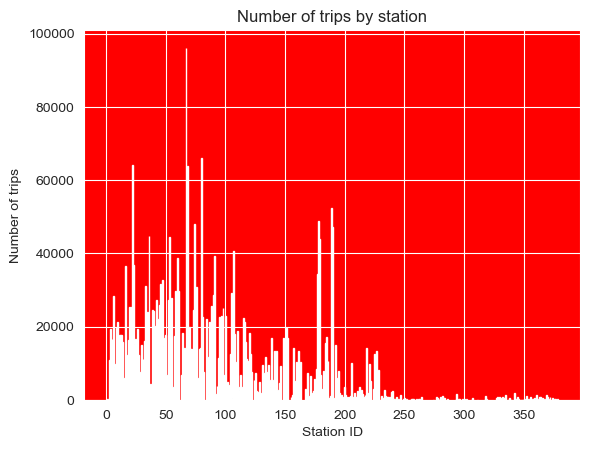

In [45]:
trips_per_station = bluebikes.groupby('start_station_id').size()
plt.rcParams['axes.facecolor'] = 'red'
plt.bar(trips_per_station.index, trips_per_station.values)
plt.xlabel('Station ID')
plt.ylabel('Number of trips')
plt.title('Number of trips by station')

plt.show()



Bar chart displaying total number of bikes available at each station to see the usage of each station

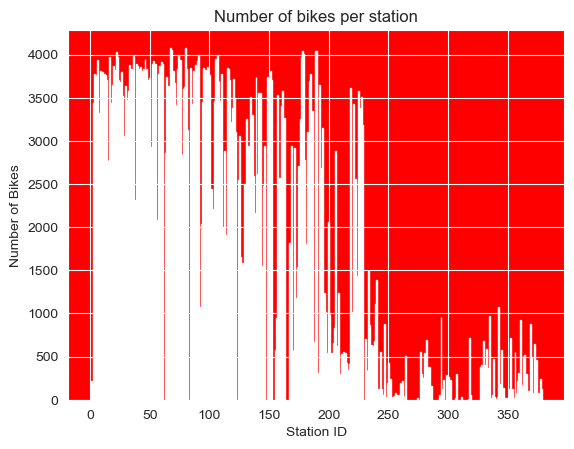

In [46]:
# Calculate number of unique bikes
bikes_per_station = bluebikes.groupby('start_station_id')['bike_id'].nunique()

plt.bar(bikes_per_station.index, bikes_per_station.values)
plt.xlabel('Station ID')
plt.ylabel('Number of Bikes')
plt.title("Number of bikes per station")
plt.show()

Print list of stations with number of bikes smaller than 100

In [47]:
bikes_per_station = bluebikes.groupby('start_station_id')['bike_id'].nunique()
station_with_few_bikes = bikes_per_station[bikes_per_station < 100].index.tolist()
for station in station_with_few_bikes:
    print(station)

229
241
245
246
248
253
254
255
256
257
258
259
263
274
293
306
311
317
319
336
337
339
340
341
343
347
348
349
350
353
355
357
360
367
368
371
373
376


Visualize growth or decline of station usage with an area chart

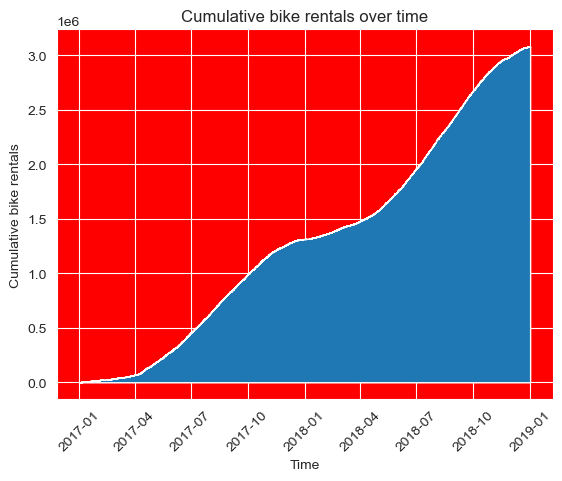

In [48]:
bluebikes['start_time'] = pd.to_datetime(bluebikes['start_time'])
# Sort the data by the start_time
bluebikes = bluebikes.sort_values('start_time')

rentals = bluebikes['start_time'].value_counts().sort_index().cumsum()

#Create area chart
plt.fill_between(rentals.index, rentals.values)
plt.xlabel("Time")
plt.ylabel("Cumulative bike rentals")
plt.title("Cumulative bike rentals over time")
plt.xticks(rotation = 45)
plt.show()

Create Heatmap to show utilization of stations at different times of days of the week.

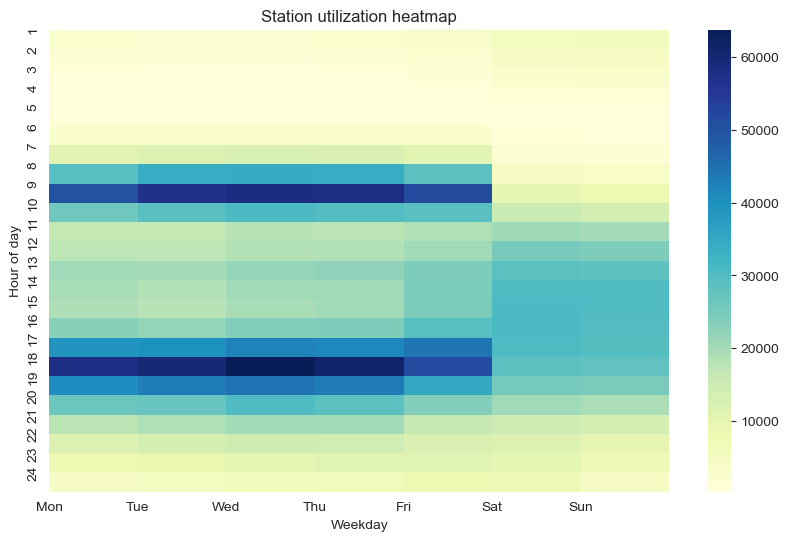

In [49]:
bluebikes['start_time'] = pd.to_datetime(bluebikes['start_time'])

bluebikes['hour'] = bluebikes['start_time'].dt.hour
bluebikes['weekday'] = bluebikes['start_time'].dt.weekday

rentals_by_hour = bluebikes.groupby(['hour', 'weekday']).size().unstack()

#heatmap_data = bluebikes_idletime.pivot_table(index='hour', columns='weekday', values='trip_id', aggfunc='count')

plt.figure(figsize=(10,6))
sns.heatmap(rentals_by_hour, cmap='YlGnBu')
plt.xlabel('Weekday')
plt.ylabel('Hour of day')
plt.title('Station utilization heatmap')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks(range(24), range(1,25))
plt.show()

Scatter plot to compare number of rentals against number of returns of each station

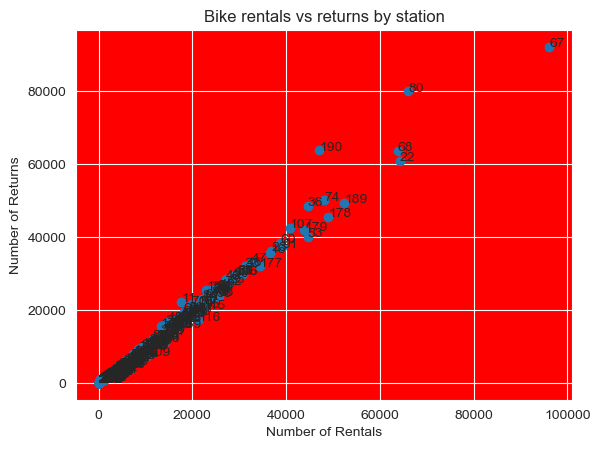

In [50]:
# Group by end_station_id and calculate the number of returns
rentals_per_station = bluebikes.groupby('start_station_id').size().reset_index(name='rentals')

returns_per_station = bluebikes.groupby('end_station_id').size().reset_index(name='returns')



# Merge the rentals and returns data based on station ID
rentals_returns_per_station = pd.merge(rentals_per_station, returns_per_station, left_on='start_station_id', right_on='end_station_id')

# Create the scatter plot
plt.scatter(rentals_returns_per_station['rentals'], rentals_returns_per_station['returns'])
plt.xlabel('Number of Rentals')
plt.ylabel('Number of Returns')
plt.title("Bike rentals vs returns by station")

# Add the station_id to the points in the plot
for i, station_id in enumerate(rentals_returns_per_station['start_station_id']):
    plt.annotate(station_id, (rentals_returns_per_station.loc[i, 'rentals'], rentals_returns_per_station.loc[i, 'returns']))
plt.show()

Idle time heatmap to see if there are specific hours of the day where idle times are higher

In [51]:
# NOT WORKING s

bluebikes['start_time'] = pd.to_datetime(bluebikes['start_time'])
bluebikes['end_time'] = pd.to_datetime(bluebikes['end_time'])

bluebikes['start_hour'] = bluebikes['start_time'].dt.hour
bluebikes['end_hour'] = bluebikes['end_time'].dt.hour

pivot = bluebikes[['idle_time', 'weekday', 'start_hour']].copy()

print(pivot.head())
# Drop rows with any missing values
pivot.dropna(subset=['idle_time', 'weekday', 'start_hour'], inplace=True)

# Make sure that the data is numeric to be able to aggregate it
pivot['idle_time'] = pd.to_numeric(pivot['idle_time'], errors='coerce')
bluebikes.pivot(index =['weekday'], columns='start_hour', values = 'idle_time')

pivot_table = pivot.pivot_table(values='idle_time', index='weekday', columns='start_hour', aggfunc ='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Idle Time Heatmap')
plt.xlabel('Hour of the Day')
plt.ylabel('Weekday')
plt.show()

         idle_time  weekday  start_hour
0                0        6           0
1                0        6           0
2                0        6           0
3                0        6           0
4  0 days 00:01:59        6           0


ValueError: Index contains duplicate entries, cannot reshape

Visualize bike rentals and returns over time to view acitivity of a specific station

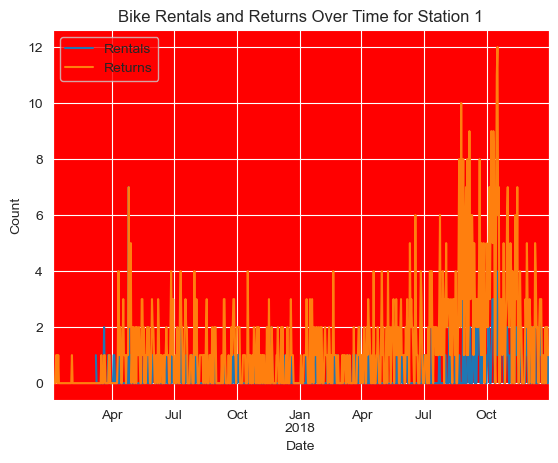

In [52]:
bluebikes['start_time'] = pd.to_datetime(bluebikes['start_time'])
bluebikes['end_time'] = pd.to_datetime(bluebikes['end_time'])

spec_station_id = 1

# Rentals
bluebikes_rentals = bluebikes[bluebikes['start_station_id'] == spec_station_id]
bluebikes_rentals.set_index('start_time', inplace=True)
# 'D' stands for daily
bluebikes_rentals.resample('D').size().plot(label='Rentals', legend=True)

# Returns
bluebikes_returns = bluebikes[bluebikes['end_station_id'] == spec_station_id]
bluebikes_returns.set_index('end_time', inplace=True)

bluebikes_returns.resample('D').size().plot(label='Returns', legend=True)

plt.title('Bike Rentals and Returns Over Time for Station {}'.format(spec_station_id))
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()



Plot idle time per station

In [1]:
# Convert idle_time to timedelta type
bluebikes['idle_time'] = pd.to_timedelta(bluebikes['idle_time'])

# Convert idle_time to minutes
bluebikes['idle_time_hours'] = bluebikes['idle_time'].dt.total_seconds() / 3600

# Calculate total idle time per start station
total_idle_time = bluebikes.groupby('start_station_id')['idle_time_hours'].mean()

total_idle_time = total_idle_time[:50]
# Create a bar plot
total_idle_time.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Idle Time per Start Station')
plt.xlabel('Start Station ID')
plt.ylabel('Mean Idle Time (Hours)')
plt.show()





NameError: name 'pd' is not defined

## Idle time of all stations in histogram

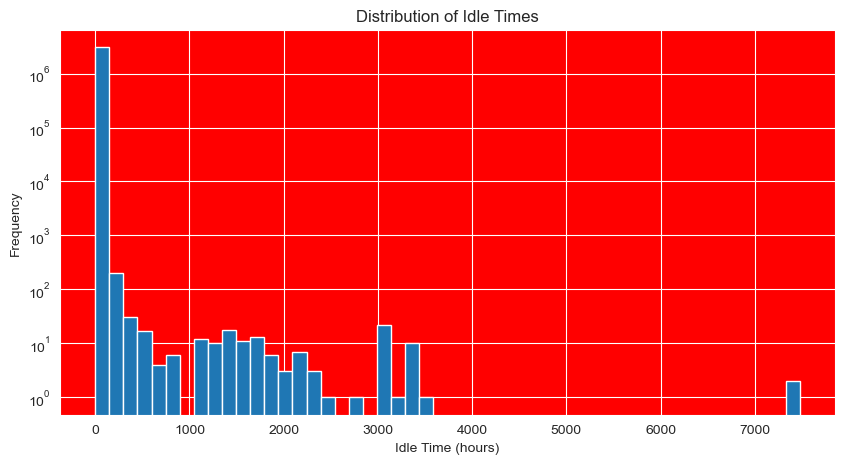

In [57]:
bluebikes['idle_time'] = pd.to_timedelta(bluebikes['idle_time'])

# Convert timedelta to total hours
bluebikes['idle_time_hours'] = bluebikes['idle_time'].dt.total_seconds() / 3600

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(bluebikes['idle_time_hours'], bins=50, log=True)
plt.title('Distribution of Idle Times')
plt.xlabel('Idle Time (hours)')
plt.ylabel('Frequency')
plt.show()

#days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

